In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Data Collection**

In [0]:
## The url for the dataset is below##
url = 'https://s3.amazonaws.com/weruns/forfun/Kickstarter/Kickstarter_2019-10-17T03_20_19_421Z.zip' 


In [0]:
#Importing libraries
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import urllib.request
from zipfile import ZipFile

In [4]:
# downloading the file contents in binary format
r = requests.get(url)
print('Downloading data file..................')

# open method to open a file on your system and write the contents
with open("minemaster1.zip", "wb") as code:
    code.write(r.content)

# Copy a network object to a local file
urllib.request.urlretrieve(url, "minemaster.zip")
with ZipFile('minemaster.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('data')   
p = os.getcwd()
p = p+'//data'
os.chdir(p)

In [5]:
# The downloaded data files are available in below location
print('The data files are located at',os.getcwd()) 

The data files are located at /content/data


In [0]:
# Collecting the downloaded data files
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# Combining all 56 files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

# exporting to csv to keep a version of the data 
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

# df is dataframe of the combined dataset
df = pd.read_csv('combined_csv.csv')

# **Data Preparation**

In [128]:
# Columns in dataframe
df.columns

Index(['level_0', 'goal', 'staff_pick', 'static_usd_rate', 'usd_pledged',
       'target', 'usd', 'days_btw_create_launch', 'campaign_length',
       'creator_projects_count', 'blurb_words', 'name_words', 'country_us',
       'index_x', 'name0', 'name1', 'name2', 'name3', 'name4', 'dm_name',
       'index_y', 'blurb0', 'blurb1', 'blurb2', 'blurb3', 'blurb4', 'blurb5',
       'blurb6', 'blurb7', 'blurb8', 'blurb9', 'blurb10', 'blurb11', 'blurb12',
       'blurb13', 'blurb14', 'blurb15', 'blurb16', 'blurb17', 'blurb18',
       'blurb19', 'dm_blurb', 'cbrt_backers_count',
       'cbrt_converted_pledged_amount', 'log_goal'],
      dtype='object')

In [0]:
# Setting indexes for the records with column 'id'
df.set_index('id')
df = df.drop_duplicates(['id'])

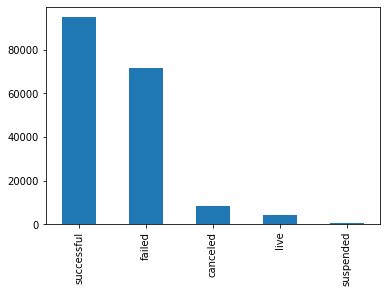

In [9]:
# Checking the levels in target
df['state'].value_counts().plot(kind='bar')

In [10]:
# Considering only 2 levels in target
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]
df.groupby(['state']).size()

state
failed        71705
successful    94824
dtype: int64

In [0]:
# Changing the date type of columns
df['created_at'] = pd.to_datetime(df['created_at'],unit='s')
df['deadline'] = pd.to_datetime(df['deadline'],unit='s')
df['launched_at'] = pd.to_datetime(df['launched_at'],unit='s')
df['state_changed_at'] = pd.to_datetime(df['state_changed_at'],unit='s')


In [0]:
# Converted bolean to 0,1 in spotlight column
df['spotlight'] = (df['spotlight']).astype(int)

In [0]:
# Converted staffpick to 0,1 from boolean
df['staff_pick'] = (df['staff_pick']).astype(int)

In [0]:
# Creating target =1 if successful and 0 if failed
df['target'] = [1 if x =='successful' else 0 for x in df['state']] 
# Creating usd_type =1 if domestic and 0 if international
df['usd'] = [1 if x =='domestic' else 0 for x in df['usd_type']]

# **Feature Engineering**

In [0]:
# Feature to capture the number of days between events
df['days_btw_create_launch'] = (df.launched_at - df.created_at).dt.days
df['days_btw_launch_stchange'] = (df.state_changed_at-df.launched_at).dt.days
df['campaign_length'] = (df.deadline - df.launched_at).dt.days

In [16]:
# Feature to capture creator name from creator text 
# Also,number of times he/she created projects
df['creator_name'] = df.creator.str.split('"').str[5]
df_crn = df.groupby('creator_name')['id'].nunique()
print('distinct creator count',df_crn)
df_crn = df_crn.to_frame()
df_crn.reset_index(level=0, inplace=True)
df = pd.merge(df, df_crn,how='left', on='creator_name')
df = df.rename(columns={"id_y": "creator_projects_count","id_x":"project_id"})


distinct creator count creator_name
                                         29
#AdventureTeam - Rebel G. Photography     1
#BLACKICEMATTERS                          1
#DareByKionde                             1
#GetAdorned by Adorn VII Boutique         1
                                         ..
豊田慶太                                      1
雨宮優                                       1
魔法少年プロジェクト                                1
좋은씨앗(이유정,이강혁)                             1
ＰＡＴＯＲＡＳＵ                                  1
Name: id, Length: 138036, dtype: int64


In [0]:
# Features to know about the length and number of words in project name and project blurb 
df = df.dropna(subset=['blurb'])
df['blurb_length'] = df['blurb'].apply(len)
df['name_length'] = df['name'].apply(len)
df['blurb_words'] = df['blurb'].str.split().str.len()
df['name_words'] = df['name'].str.split().str.len()


In [0]:
# Feature to know the category and sub-category of the project from category text column
df['sub_category'] = df.category.str.split('"').str[5]
df['main_category'] = df.category.str.split('"').str[9]
df['main_category'] = df.sub_category.str.split('/').str[0]

In [0]:
# Binning categorical variables
# binning country if it is us or not
df['country_us'] = [1 if x =='US' else 0 for x in df['country']]

In [0]:
# Feature to show the state or country from location column
df['origin_location'] = df.location.str.split(',').str[4]
df['origin_location'] = df['origin_location'].str.replace('"','')

In [0]:
# dropping columns 
df.drop(columns=['creator','slug','urls','created_at','launched_at','state_changed_at','deadline','friends','country', 'is_backing','is_starred','permissions','category','country_displayable_name','currency', 'currency_symbol','currency_trailing_code', 'current_currency','disable_communication','fx_rate','pledged','is_starrable','location','photo','profile','source_url'],inplace = True)
df.drop(columns = ['usd_type','state'],inplace = True)
df.drop(columns = ['origin_location'],inplace = True)
df.drop(columns = ['creator_name'],inplace = True)

# renaming column names
df = df.rename(columns={"name": "project_name", "blurb": "project_blurb"})

**Text Modelling**

In [0]:
pd.set_option('display.max_columns', 50)
df.set_index('project_id', inplace = True)

In [0]:
## libraries for text topics 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#import pyLDAvis.sklearn
import re

In [0]:
# Function to show the first 20 text topics 
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [0]:
# Function for creating text topics
def text_topic(df,column,id,num_topics,topicname,dominant_topic_name):
  df.reset_index(inplace=True)
  df2 = df[[column,id]]
  df2.columns = ['sentence', id]
  df2['sentence'] = df2['sentence'].map(lambda x: re.sub(r'\W+', ' ', x))
  vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=300,             # max number of uniq words
                            )
  data_vectorized = vectorizer.fit_transform(df2['sentence'])
  lda_model = LatentDirichletAllocation(n_components=num_topics, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
  lda_output = lda_model.fit_transform(data_vectorized)
  
  topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)        
  # Topic - Keywords Dataframe
  df_topic_keywords = pd.DataFrame(topic_keywords)
  df_topic_keywords.columns = ['Word1 '+str(i) for i in range(df_topic_keywords.shape[1])]
  df_topic_keywords.index = ['name_Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
  # Create Document - Topic Matrix
  lda_output = lda_model.transform(data_vectorized)
  # column names with number of topics which is num_topics.
  topicnames = [topicname + str(i) for i in range(num_topics)]
  # index names
  docnames = ["Doc" + str(i) for i in range(len(df))]
  # Make the pandas dataframe
  df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
  print(df_document_topic)
  # Get dominant topic for each document
  dominant_topic = np.argmax(df_document_topic.values, axis=1)
  df_document_topic[dominant_topic_name] = dominant_topic
  df_document_topic.reset_index(inplace=True)
  df_sent_topic= pd.merge(df, df_document_topic, left_index=True, right_index=True)
  #df_sent_topic1.drop('index', axis=1, inplace=True)
  return df_sent_topic

In [26]:
#creating 5 text topics for "project name" text field
df_new = text_topic(df,column = 'project_name',id = 'project_id',num_topics = 5,topicname='name',dominant_topic_name='dm_name')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


           name0  name1  name2  name3  name4
Doc0         0.1   0.60   0.10   0.10   0.10
Doc1         0.1   0.10   0.10   0.10   0.60
Doc2         0.1   0.10   0.10   0.60   0.10
Doc3         0.1   0.10   0.10   0.60   0.10
Doc4         0.8   0.05   0.05   0.05   0.05
...          ...    ...    ...    ...    ...
Doc166522    0.1   0.10   0.10   0.10   0.60
Doc166523    0.2   0.20   0.20   0.20   0.20
Doc166524    0.2   0.20   0.20   0.20   0.20
Doc166525    0.6   0.10   0.10   0.10   0.10
Doc166526    0.2   0.20   0.20   0.20   0.20

[166527 rows x 5 columns]


In [27]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166527 entries, 0 to 166526
Data columns (total 30 columns):
project_id                  166527 non-null int64
backers_count               166527 non-null int64
project_blurb               166527 non-null object
converted_pledged_amount    166527 non-null int64
goal                        166527 non-null float64
project_name                166527 non-null object
spotlight                   166527 non-null int64
staff_pick                  166527 non-null int64
static_usd_rate             166527 non-null float64
usd_pledged                 166527 non-null float64
target                      166527 non-null int64
usd                         166527 non-null int64
days_btw_create_launch      166527 non-null int64
days_btw_launch_stchange    166527 non-null int64
campaign_length             166527 non-null int64
creator_projects_count      166527 non-null int64
blurb_length                166527 non-null int64
name_length                 166

In [28]:
#creating 20 text topics for "project blurb" text field
df = text_topic(df_new,column = 'project_blurb',id = 'project_id',num_topics = 20,topicname='blurb',dominant_topic_name='dm_blurb')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


           blurb0  blurb1  blurb2  blurb3  blurb4  blurb5  blurb6  blurb7  \
Doc0         0.21    0.01    0.01    0.01    0.01    0.01    0.01    0.41   
Doc1         0.13    0.01    0.13    0.01    0.01    0.01    0.01    0.13   
Doc2         0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.13   
Doc3         0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01   
Doc4         0.01    0.01    0.11    0.01    0.01    0.01    0.01    0.01   
...           ...     ...     ...     ...     ...     ...     ...     ...   
Doc166522    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05   
Doc166523    0.01    0.01    0.41    0.01    0.01    0.01    0.21    0.01   
Doc166524    0.02    0.35    0.02    0.02    0.35    0.02    0.02    0.02   
Doc166525    0.02    0.02    0.02    0.02    0.02    0.02    0.35    0.02   
Doc166526    0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.02   

           blurb8  blurb9  blurb10  blurb11  blurb12  blurb13  blurb14  \
D

# **Exploratory Data Analysis**

0       13501
1       12842
2        8925
3        6074
4        4399
        ...  
1988        1
4295        1
2500        1
8897        1
8379        1
Name: backers_count, Length: 3219, dtype: int64


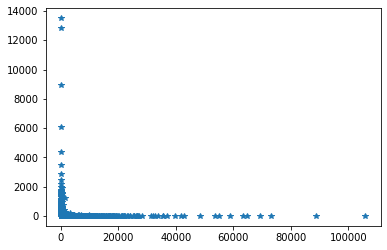

In [29]:
import pylab as p  
x1 = df['backers_count'].unique()
y1 = df['backers_count'].value_counts()
print(y1[0:])
p.plot(x1, y1, '*')

In [30]:
# Checking skewness of interval variables
print('actual skewness')
df.skew(axis = 0, skipna = True) 

actual skewness


level_0                      0.000000
project_id                  -0.003211
backers_count               45.278441
converted_pledged_amount    52.290434
goal                        68.706619
spotlight                   -0.280403
staff_pick                   2.223947
static_usd_rate             -1.200129
usd_pledged                 52.273529
target                      -0.280403
usd                         -1.185897
days_btw_create_launch       7.597368
days_btw_launch_stchange     0.959248
campaign_length              0.959176
creator_projects_count       8.118562
blurb_length                -1.384570
name_length                  0.031280
blurb_words                 -0.810701
name_words                   0.240128
country_us                  -0.923799
name0                        1.671293
name1                        1.675775
name2                        1.614572
name3                        1.670297
name4                        1.422688
dm_name                      0.780451
blurb0      

Observed that backers_count, convereted_pledged_amount, goal are having high skewness.

In [0]:
# Transorming the highly skewed variables
# Applying cuberoot transformation on backers_count, converted_pledged_amount
df['cbrt_backers_count'] = np.cbrt(df['backers_count'])
df['cbrt_converted_pledged_amount'] = np.cbrt(df['converted_pledged_amount'])

# Applying logarithmic transformation on goal
df['log_goal'] = np.log(df['goal'])

In [32]:
# Checking skewness of interval variables after correcting
print('skewness after transformation')
df.skew(axis = 0, skipna = True) 

skewness after transformation


level_0                           0.000000
project_id                       -0.003211
backers_count                    45.278441
converted_pledged_amount         52.290434
goal                             68.706619
spotlight                        -0.280403
staff_pick                        2.223947
static_usd_rate                  -1.200129
usd_pledged                      52.273529
target                           -0.280403
usd                              -1.185897
days_btw_create_launch            7.597368
days_btw_launch_stchange          0.959248
campaign_length                   0.959176
creator_projects_count            8.118562
blurb_length                     -1.384570
name_length                       0.031280
blurb_words                      -0.810701
name_words                        0.240128
country_us                       -0.923799
name0                             1.671293
name1                             1.675775
name2                             1.614572
name3      

0.000000     13501
1.000000     12842
1.259921      8925
1.442250      6074
1.587401      4399
             ...  
14.345162        1
12.363856        1
20.373000        1
14.435304        1
15.791567        1
Name: cbrt_backers_count, Length: 3219, dtype: int64


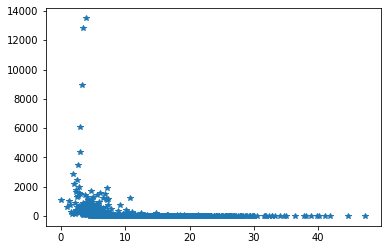

In [33]:
# checking the cbrt_backers_count distribution after tranformation
x1 = df['cbrt_backers_count'].unique()
y1 = df['cbrt_backers_count'].value_counts()
print(y1[0:])
p.plot(x1, y1, '*')

In [0]:
## Dropping columns
df.drop(columns = ['project_blurb','project_name','main_category','sub_category','spotlight'],inplace = True)

In [35]:
# Checking missing values in each column
df.isnull().sum()

level_0                          0
project_id                       0
backers_count                    0
converted_pledged_amount         0
goal                             0
staff_pick                       0
static_usd_rate                  0
usd_pledged                      0
target                           0
usd                              0
days_btw_create_launch           0
days_btw_launch_stchange         0
campaign_length                  0
creator_projects_count           0
blurb_length                     0
name_length                      0
blurb_words                      0
name_words                       0
country_us                       0
index_x                          0
name0                            0
name1                            0
name2                            0
name3                            0
name4                            0
dm_name                          0
index_y                          0
blurb0                           0
blurb1              

In [0]:
# Spliting the data to train and validation
# Split into 70% training and 30% testing set
from sklearn.model_selection import train_test_split
features = df.loc[:, df.columns != 'target']  #independent columns
targets = df.loc[:,'target']    #target column 
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3)

In [113]:
### Sampling the training data to get equal proportions of target
# Checking the current proportion in the training set
num_0 = len(y[y==0])
num_1 = len(y[y==1])
print('Actual proportions of classes in training set',num_0,num_1)

Actual proportions of classes in training set 50211 66357


In [114]:
# Random undersampling
undersampled_data = pd.concat([ X[y==1].sample(num_0) , X[y==0] ])
print('length of training set after undersampling',len(undersampled_data))
sampled_X = undersampled_data
sampled_y = pd.concat([ y[y==1].sample(num_0) , y[y==0] ])

length of training set after undersampling 100422


corelation map before removing corelated variables


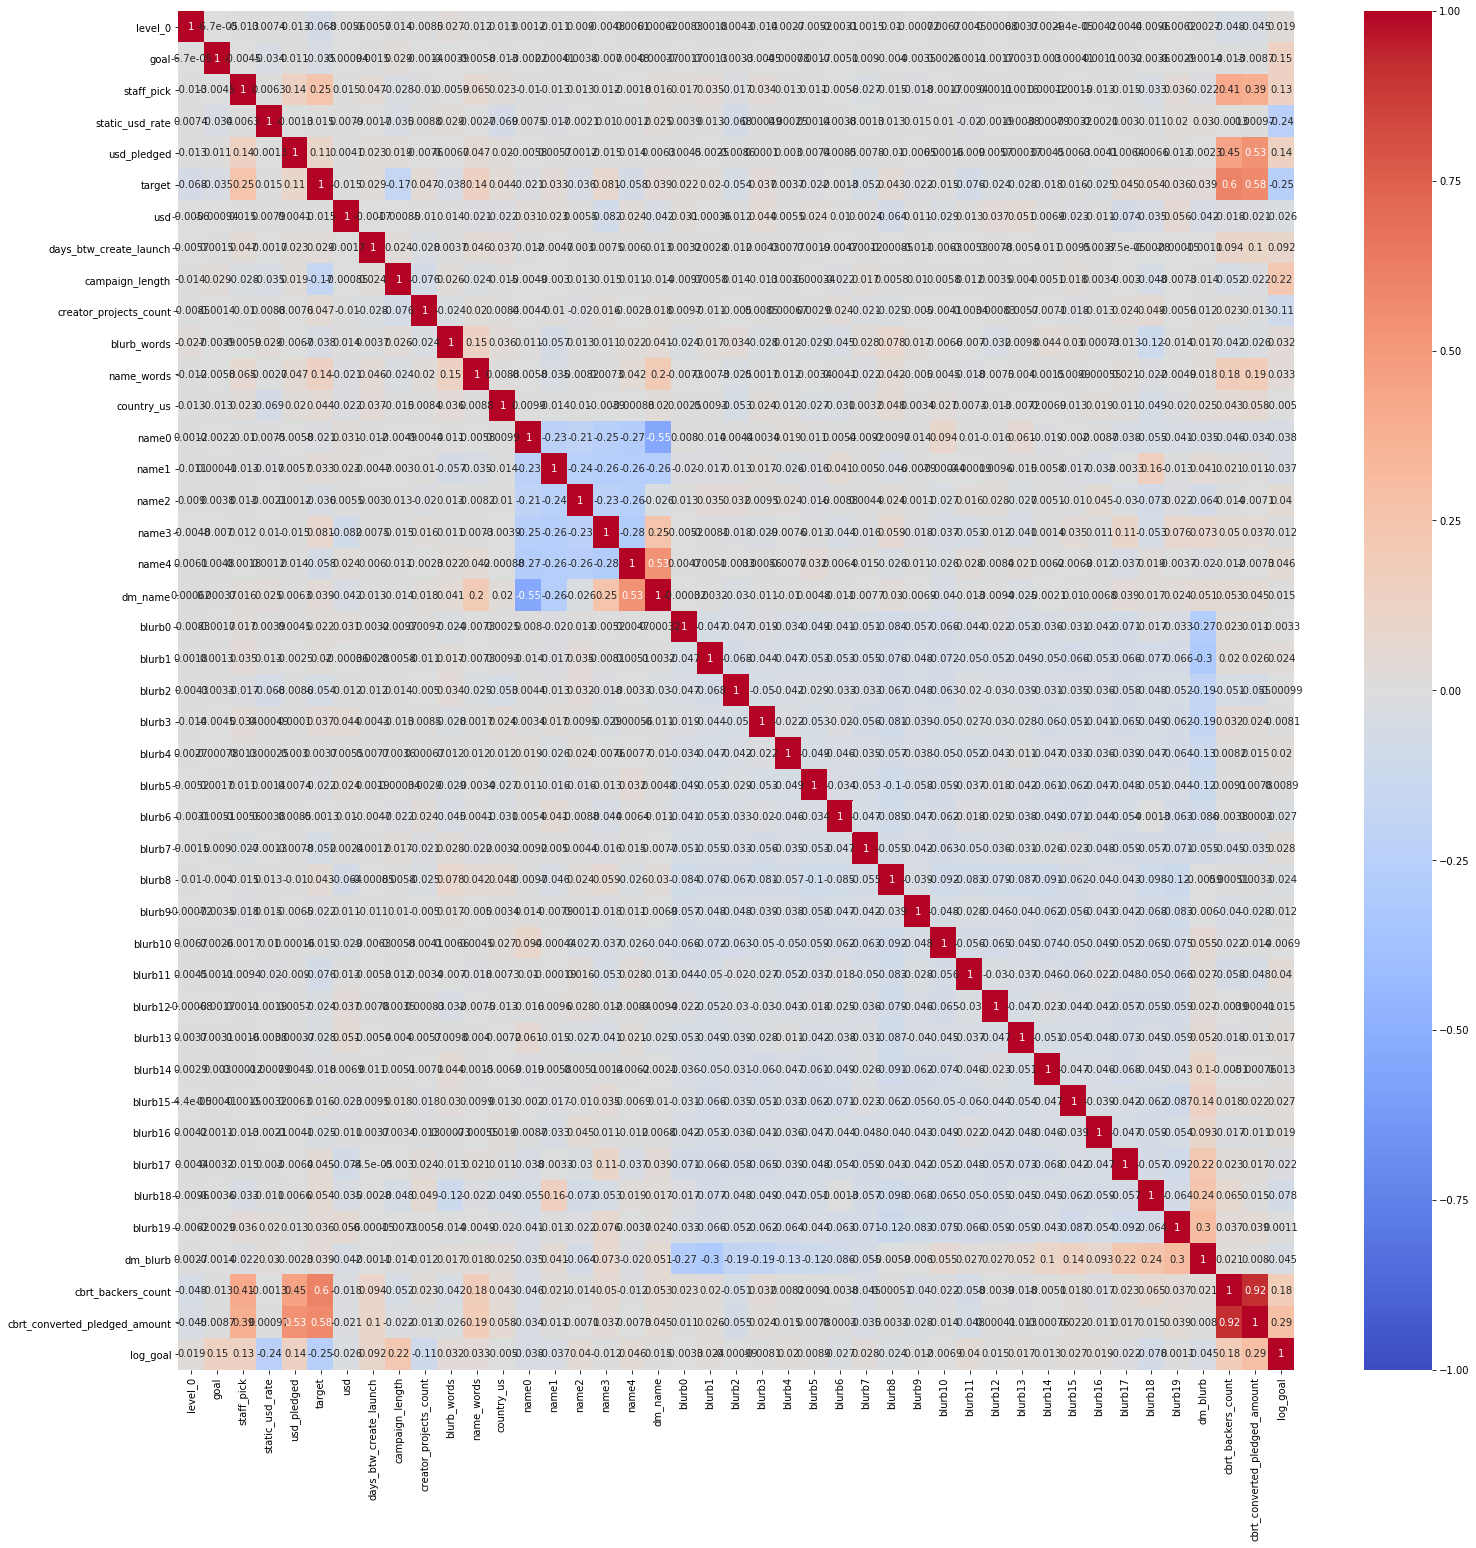

In [115]:
# Checking corelation among variables
# Before removing corealted variables
print('corelation map before removing corelated variables')
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(),vmin=-1,cmap='coolwarm',annot=True)

From the corelation matrix it is clear that (blurb length,blurb words), (name_length, name_words),(campaign_length,days_btw_launch_stchange) are the highly corelated pairs.

In [0]:
#Removing corelated variables
df.drop(columns = ['project_id','backers_count','converted_pledged_amount','blurb_length','name_length','days_btw_launch_stchange'],inplace = True)


corelation map after removing corelated variables


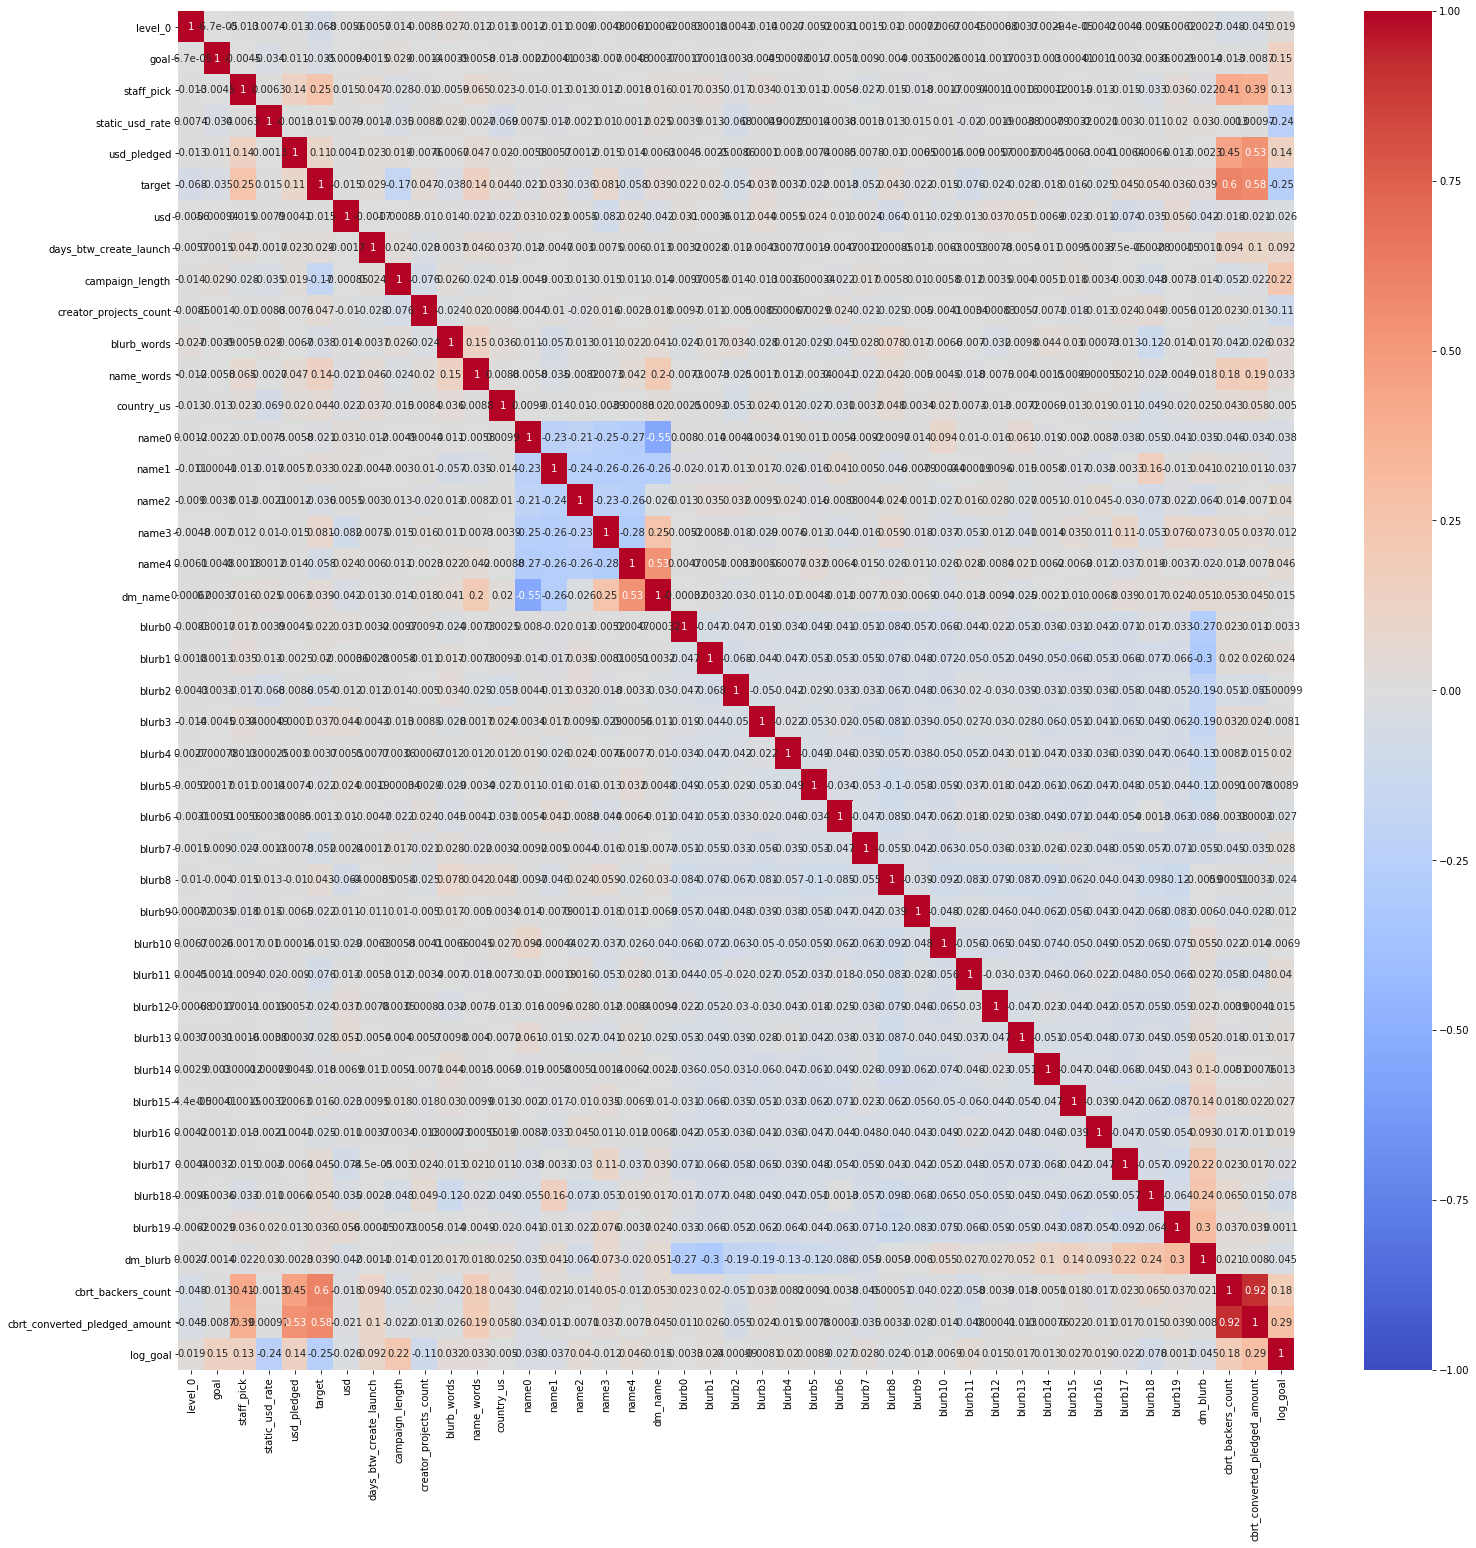

In [117]:
#after removing corelated variables
print('corelation map after removing corelated variables')
plt.figure(figsize=(25,25))
sns_plot = sns.heatmap(df.corr(),vmin=-1,cmap='coolwarm',annot=True)

In [0]:
# Dropping few unwanted columns 
X.drop(columns = ['index_x','index_y'],inplace = True)
X_test.drop(columns = ['index_x','index_y'],inplace = True)

In [0]:
X.drop(columns = ['project_id'],inplace = True)
X_test.drop(columns = ['project_id'],inplace = True)

# **Variable Selection**

In [120]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X, y)
print('Before variable selection, the number of varibles are',X.shape)
model = SelectFromModel(lsvc, prefit=True)
X = model.transform(X)
print('After variable selection, the number of variables are',X.shape)

Before variable selection, the number of varibles are (116568, 42)
After variable selection, the number of variables are (116568, 11)


In [121]:
##df is final dataframe
X_test = model.transform(X_test)
print('Final shape of training features',X.shape)
print('Final shape of test features',X_test.shape)
print('Final shape of training labels',y.shape)
print('Final shape of test labels',y_test.shape)


Final shape of training features (116568, 11)
Final shape of test features (49959, 11)
Final shape of training labels (116568,)
Final shape of test labels (49959,)


# **Predictive Modelling**

This section I implemented 4 ML Alogorithms and tuned their Hyper-parameters to increase the prediction accuracy. The models are:


1.   K-Nearest Neighbor
2.   Random Forest
3.   Gradient Boosting
4.   Aritificial Neural Networks







# K-Nearest Neighbor

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

from sklearn import metrics
def misclassification_rate(y_true,y_pred_class):
  confusion = metrics.confusion_matrix(y_test, y_pred_class)
  #[row, column]
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  classification_error = (FP + FN) / float(TP + TN + FP + FN)
  return classification_error


In [47]:
# KNN with default parameters
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X, y)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',metric_params=None, n_jobs=1, n_neighbors=5, p=2,weights='uniform')
y_pred = model.predict(X_test)

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('baseline auc of KNN', roc_auc)

baseline auc of KNN 0.8814868924961342


In [48]:
# Misclassification rate
m = misclassification_rate(y_test,y_pred)
print(f'base line misclassfication rate for KNN base model ={m:.4}')
print(f'base line accuracy for KNN base model ={1-m:.4}')

base line misclassfication rate for KNN base model =0.1137
base line accuracy for KNN base model =0.8863


In [0]:
# Function for KNN model training and testing
def model_fit(model,X,y):
   model.fit(X, y)
   train_pred = model.predict(X)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   acc = np.sum(y==train_pred)/y.shape
   train_results.append(roc_auc)
   train_results1.append(acc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
   acc1 = np.sum(y_test==y_pred)/y_pred.shape
   test_results1.append(acc1)
   return train_results,test_results,train_results1,test_results1

# Function to plot the results
def plot(x_label,paramter,train_results,test_results,train_results1,test_results1):
  line1, = plt.plot(paramter, train_results, 'b', label="Train AUC")
  line2, = plt.plot(paramter, test_results, 'r', label="Test AUC")
  plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
  plt.ylabel('AUC score')
  plt.xlabel(x_label)
  plt.show()
  line1, = plt.plot(paramter, train_results1, 'b', label="Train Accuracy")
  line2, = plt.plot(paramter, test_results1, 'r', label="Test Accuracy")
  plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
  plt.ylabel('Accuracy')
  plt.xlabel(x_label)
  plt.show()


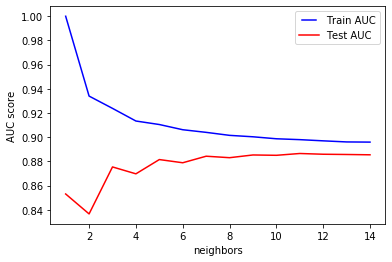

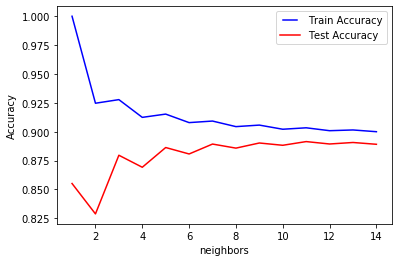

In [50]:
# Hyper-parameter tuned : neighbors
neighbors = list(range(1,15))
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for n in neighbors:
   model = KNeighborsClassifier(n_neighbors=n)
   train_results,test_results,train_results1,test_results1 = model_fit(model,X,y)
plot('neighbors',neighbors,train_results,test_results,train_results1,test_results1)

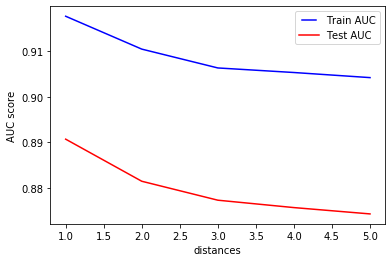

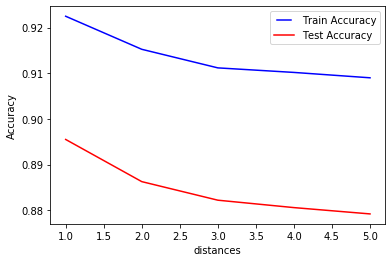

In [51]:
# Hyper-parameter tuned : power parameter/distance
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for p in distances:
   model = KNeighborsClassifier(p=p)
   train_results,test_results,train_results1,test_results1 = model_fit(model,X,y)
plot('distances',distances,train_results,test_results,train_results1,test_results1)

In [52]:
# Hyper-parameter using grid search

from sklearn.model_selection import GridSearchCV

grid_params = {'n_neighbors':[5,7,9],'p':[1,2]}
gs = GridSearchCV(KNeighborsClassifier(),grid_params,verbose=1,cv=3,n_jobs=-1)
grid_result = gs.fit(X,y)

print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.4min finished


Best Accuracy for 0.8966 using {'n_neighbors': 9, 'p': 1}
mean=0.8933, std=0.0008437 using {'n_neighbors': 5, 'p': 1}
mean=0.885, std=0.0008396 using {'n_neighbors': 5, 'p': 2}
mean=0.8961, std=0.0006619 using {'n_neighbors': 7, 'p': 1}
mean=0.8872, std=0.0009915 using {'n_neighbors': 7, 'p': 2}
mean=0.8966, std=0.0006613 using {'n_neighbors': 9, 'p': 1}
mean=0.8882, std=0.001075 using {'n_neighbors': 9, 'p': 2}


In [53]:
# Checking the best model after hyper-parameter tuning on validation data

gs_best = KNeighborsClassifier(p=1,n_neighbors=9)
gs_best_result = gs_best.fit(X,y)
y_pred = gs_best_result.predict(X_test)
m = misclassification_rate(y_test,y_pred)
print(f'Misclassfication rate from KNN best model ={m:.4}')
accuracy = 1-m
print(f'Accuracy from KNN best model ={accuracy:.4}')

Misclassfication rate from KNN best model =0.1014
Accuracy from KNN best model =0.8986


# Random Forest

In [54]:
# Random Forest with default parameters
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X, y)
y_pred = rf.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('base auc for RF',roc_auc)
print('base misclassification rate for RF',misclassification_rate(y_test,y_pred))

base auc for RF 0.9876988694723768
base misclassification rate for RF 0.011129125883224244


training needs to stop at n_estimators 19


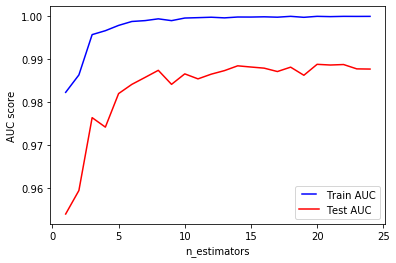

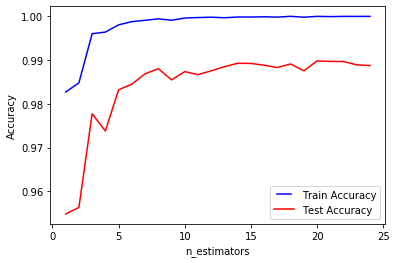

In [55]:
# Hyper-parameter tuned : n_estimators
n_estimators = list(range(1,25))
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   train_results,test_results,train_results1,test_results1 = model_fit(rf,X,y)
print('training needs to stop at n_estimators',np.argmax(test_results))
plot('n_estimators',n_estimators,train_results,test_results,train_results1,test_results1)

training needs to stop at max_depth 17


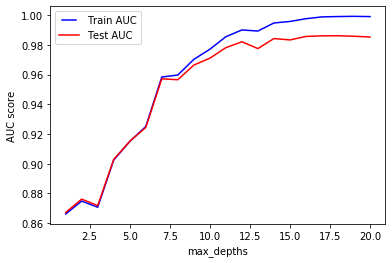

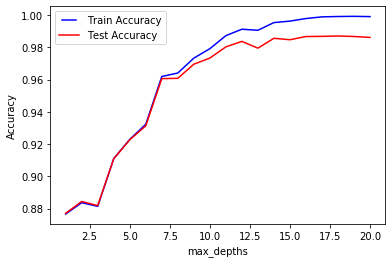

In [56]:
# Hyper-parameter tuned : max_depth
max_depths = np.linspace(1, 20, 20, endpoint=True)
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1,n_estimators =10)
   train_results,test_results,train_results1,test_results1 = model_fit(rf,X,y)
print('training needs to stop at max_depth',np.argmax(test_results))
plot('max_depths',max_depths,train_results,test_results,train_results1,test_results1)


training needs to stop at min_sample splits :  0


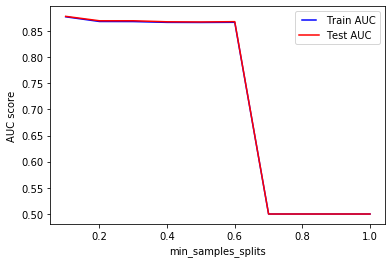

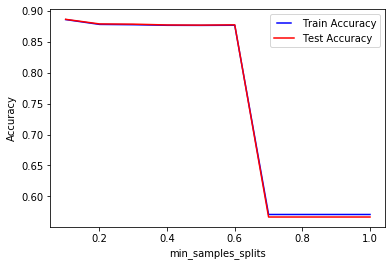

In [57]:
# Hyper-parameter tuned : MIN Splits
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   train_results,test_results,train_results1,test_results1 = model_fit(rf,X,y)
print('training needs to stop at min_sample splits : ',np.argmax(test_results))
plot('min_samples_splits',min_samples_splits,train_results,test_results,train_results1,test_results1)


training needs to stop at min_samples_leafs :  0


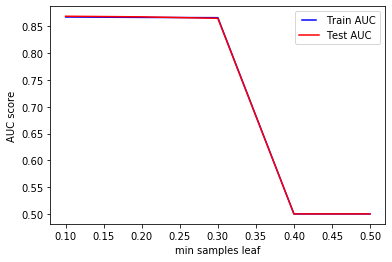

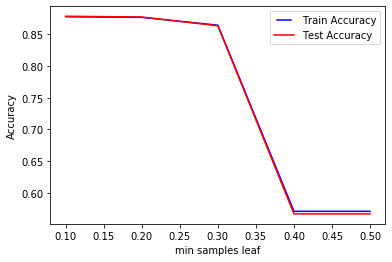

In [58]:
# Hyper-parameter tuned : min leafes
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   train_results,test_results,train_results1,test_results1 = model_fit(rf,X,y)
print('training needs to stop at min_samples_leafs : ',np.argmax(test_results))
plot('min samples leaf',min_samples_leafs,train_results,test_results,train_results1,test_results1)


training needs to stop at min_samples_leafs :  14


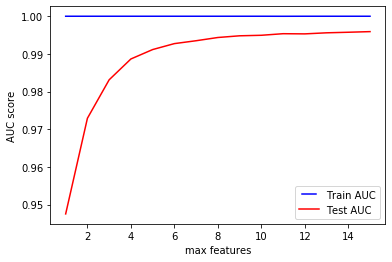

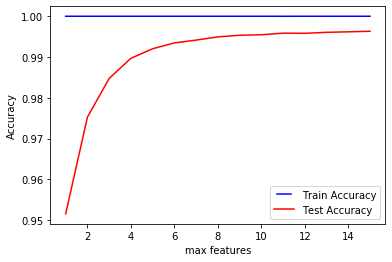

In [59]:
# Hyper-parameter tuned : max features
max_features = list(range(1,X.shape[1]))
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature)
   train_results,test_results,train_results1,test_results1 = model_fit(rf,X,y)
print('training needs to stop at min_samples_leafs : ',np.argmax(test_results))
plot('max features',max_features,train_results,test_results,train_results1,test_results1)


In [0]:
# Hyper-parameter using randomized search

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [23,14]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [18,15]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [123]:
# The base model to tune is: 
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)
print('Random Forest best parameters are :')
rf_random.best_params_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  8.1min finished


Random Forest best parameters are :


{'bootstrap': False,
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 23}

In [124]:
# Checking this Random forest best model performance on validation data
rf_best = RandomForestClassifier(bootstrap=False,max_depth=24,max_features = 'sqrt',min_samples_leaf=1,min_samples_split=10,n_estimators=17)
rf_best_result = rf_best.fit(X,y)
y_pred = rf_best_result.predict(X_test)
m = misclassification_rate(y_test,y_pred)
print(f'Misclassfication rate from Random Forest best model ={m:.4}')
accuracy = 1-m
print(f'Accuracy from Random Forest best model ={accuracy:.4}')

Misclassfication rate from Random Forest best model =0.007386
Accuracy from Random Forest best model =0.9926


# Gradient Boosting

In [63]:
# Gradient boosting with default parameters
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
x_train = X
y_train = y
x_test = X_test
model.fit(X, y)
y_pred = model.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('baseline auc of Gradient Boosting ',roc_auc)
print('misclassifiction rate for base line of Gradient Boosting ',misclassification_rate(y_test,y_pred))


baseline auc of Gradient Boosting  0.9820327515428
misclassifiction rate for base line of Gradient Boosting  0.015692868151884545


training needs to stop at learning rate :  0


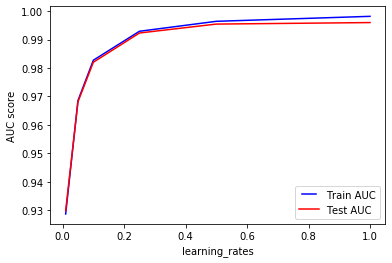

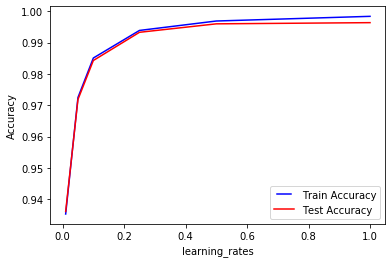

In [64]:
# Hyper-parameter tuned : learning rates
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   train_results,test_results,train_results1,test_results1 = model_fit(model,X,y)
print('training needs to stop at learning rate : ',np.argmax(test_results))
plot('learning_rates',learning_rates,train_results,test_results,train_results1,test_results1)


training needs to stop at n_estimators :  8


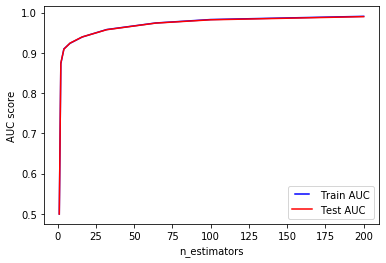

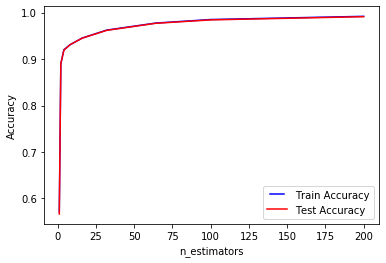

In [65]:
# Hyper-parameter tuned : n_estimators
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   train_results,test_results,train_results1,test_results1 = model_fit(model,X,y)
print('training needs to stop at n_estimators : ',np.argmax(test_results))
plot('n_estimators',n_estimators,train_results,test_results,train_results1,test_results1)


training needs to stop at min_samples_splits :  0


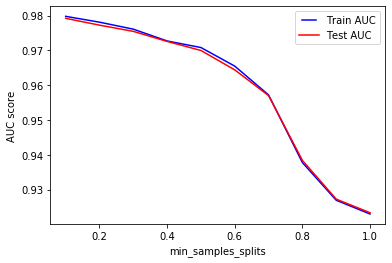

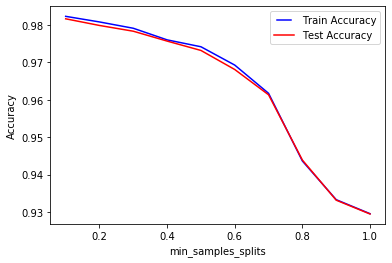

In [66]:
# Hyper-parameter tuned : min split
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for min_samples_split in min_samples_splits:
   model = GradientBoostingClassifier(min_samples_split=min_samples_split)
   train_results,test_results,train_results1,test_results1 = model_fit(model,X,y)
print('training needs to stop at min_samples_splits : ',np.argmax(test_results))
plot('min_samples_splits',min_samples_splits,train_results,test_results,train_results1,test_results1)


training needs to stop at min_samples_leafs :  0


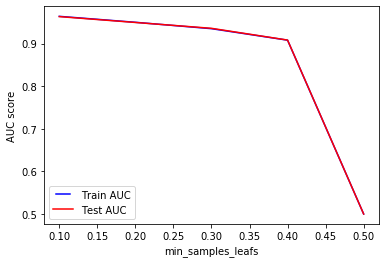

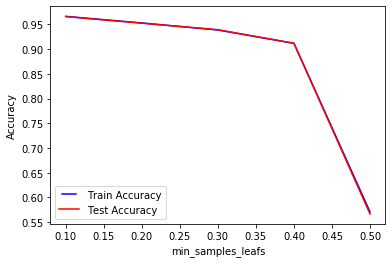

In [67]:
# Hyper-parameter tuned : min leaf
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for min_samples_leaf in min_samples_leafs:
   model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
   train_results,test_results ,train_results1,test_results1 = model_fit(model,X,y)
print('training needs to stop at min_samples_leafs : ',np.argmax(test_results))
plot('min_samples_leafs',min_samples_leafs,train_results,test_results ,train_results1,test_results1)


training needs to stop at max_features :  11


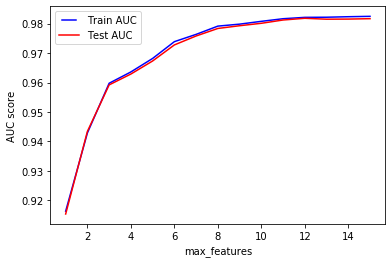

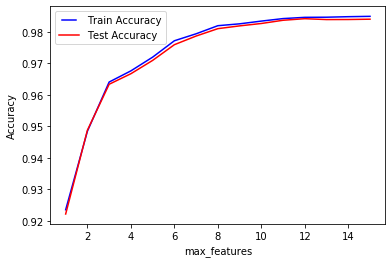

In [68]:
# Hyper-parameter tuned : max features
max_features = list(range(1,x_train.shape[1]))
train_results = []
test_results = []
train_results1 = []
test_results1 = []
for max_feature in max_features:
   model = GradientBoostingClassifier(max_features=max_feature)
   train_results,test_results,train_results1,test_results1 = model_fit(model,X,y)
print('training needs to stop at max_features : ',np.argmax(test_results))
plot('max_features',max_features,train_results,test_results,train_results1,test_results1)


In [0]:
# Hyper-parameter using randomized search

from sklearn.model_selection import RandomizedSearchCV
#learning rate
learning_rate = [0.2,0.3]
# Number of trees in random forest
n_estimators = [25,50]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [18,15]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


In [126]:
# The base model to tune
gb = GradientBoostingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X, y)
print('Gradient Boosting best parameters are :')
gb_random.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 64.0min finished


Gradient Boosting best parameters are :


{'learning_rate': 0.3,
 'max_depth': 18,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 50}

In [127]:
# checking this Gradient boosting best model performance on validation data
rf_best = RandomForestClassifier(bootstrap=False,max_depth=24,max_features = 'sqrt',min_samples_leaf=1,min_samples_split=10,n_estimators=17)
rf_best_result = rf_best.fit(X,y)
y_pred = rf_best_result.predict(X_test)
m = misclassification_rate(y_test,y_pred)
print(f'Misclassfication rate from Random Forest best model ={m:.4}')
accuracy = 1-m
print(f'Accuracy from Random Forest best model ={accuracy:.4}')

Misclassfication rate from Random Forest best model =0.008147
Accuracy from Random Forest best model =0.9919


# Artificial Neural Networks

In this ANN models, I implemented 4 models.
1. default parameters
2. Using custom learning rate
3. Using RMS optimizer
4. Hyper parameter tuned model

In [0]:
# Importing libraries
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

In [0]:
# Converting class vectors to binary class matrices
num_classes = 2
y = keras.utils.to_categorical(y, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# 1. DEFAULT MODEL
# setting parameters to default ANN model
epochs=60
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [76]:
# Building the model
input_dim = X.shape[1]

lr_model = Sequential()
lr_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim)) 
lr_model.add(Dropout(0.1))
lr_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [77]:
# Compiling the model
lr_model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['acc'])

# Fitting the model
batch_size = 200
lr_model_history = lr_model.fit(X, y,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

score = lr_model.evaluate(X_test, y_test, verbose=0)
print('Test loss of base DNN:', score[0])
print('Test accuracy of base DNN:', score[1])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 116568 samples, validate on 49959 samples
Epoch 1/60





116568/116568 [==============================] - 2s 18us/step - loss: 0.8644 - acc: 0.6329 - val_loss: 0.7462 - val_acc: 0.7380
Epoch 2/60
116568/116568 [==============================] - 2s 13us/step - loss: 0.6849 - acc: 0.6199 - val_loss: 0.6649 - val_acc: 0.6049
Epoch 3/60
116568/116568 [==============================] - 1s 13us/step - loss: 0.6535 - acc: 0.5905 - val_loss: 0.6571 - val_acc: 0.5666
Epoch 4/60
116568/116568 [==============================] - 2s 14us/step - loss: 0.6585 - acc: 0.5706 - val_loss: 0.6572 - val_acc: 0.5666
Epoch 5/60
116568/116568 [==============================] - 2s 14us/step - loss: 0.6570 - acc: 0.5706 - val_loss: 0.6534 - val_acc: 0.5666
Epoch 6/60
116568/116568 [==============================] - 2s 14us/step - loss: 0.6531 - acc: 0.5706 - val_loss: 0.6521 - val_acc: 0.5666
Epoch 7/60


In [0]:
# Function : Plot for the loss function
def loss_fn(model_hst):
  fig, ax = plt.subplots(1, 1, figsize=(10,6))
  ax.plot(np.sqrt(model_hst.history['loss']), 'r', label='train')
  ax.plot(np.sqrt(model_hst.history['val_loss']), 'b' ,label='val')
  ax.set_xlabel(r'Epoch', fontsize=20)
  ax.set_ylabel(r'Loss', fontsize=20)
  ax.legend()
  ax.tick_params(labelsize=20)

# Function : Plot for the accuracy
def acc_plot(model_hst):
  fig, ax = plt.subplots(1, 1, figsize=(10,6))
  ax.plot(np.sqrt(lr_model_history.history['acc']), 'r', label='train')
  ax.plot(np.sqrt(lr_model_history.history['val_acc']), 'b' ,label='val')
  ax.set_xlabel(r'Epoch', fontsize=20)
  ax.set_ylabel(r'Accuracy', fontsize=20)
  ax.legend()
  ax.tick_params(labelsize=20)

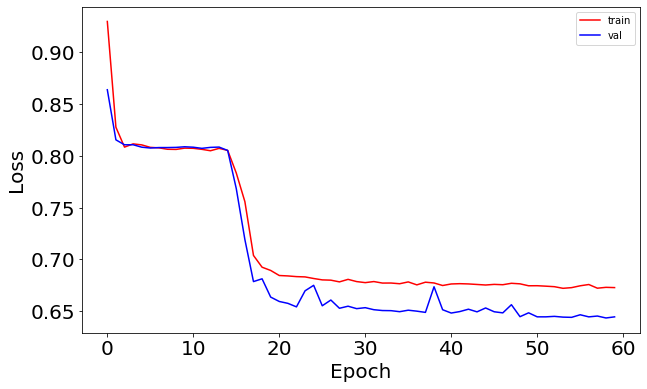

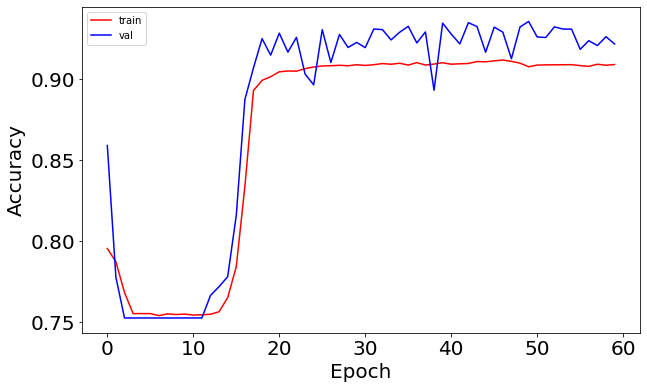

In [79]:
loss_fn(lr_model_history)
acc_plot(lr_model_history)

In [0]:
# 2. Applying Custom Learning rate
# applying custom learning rate change using LearningRateScheduler solution
epochs = 60
learning_rate = 0.1 # initial learning rate
decay_rate = 0.1
momentum = 0.8

# define the optimizer function
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

input_dim = X.shape[1]
num_classes = 2
batch_size = 200


In [0]:
# Building the model
exponential_decay_model = Sequential()
exponential_decay_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim))
exponential_decay_model.add(Dropout(0.1))
exponential_decay_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
exponential_decay_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# compiling the model
exponential_decay_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])


In [82]:
# Defining the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate
    
# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]

# Invoke the LearningRateScheduler during the .fit() phase
exponential_decay_model_history = exponential_decay_model.fit(X, y,batch_size=batch_size,epochs=epochs,callbacks=callbacks_list,verbose=1,validation_data=(X_test, y_test))


Train on 116568 samples, validate on 49959 samples
Epoch 1/60
116568/116568 [==============================] - 2s 15us/step - loss: 6.8597 - acc: 0.5695 - val_loss: 6.9862 - val_acc: 0.5666
Epoch 2/60
116568/116568 [==============================] - 2s 13us/step - loss: 6.9204 - acc: 0.5706 - val_loss: 6.9862 - val_acc: 0.5666
Epoch 3/60
116568/116568 [==============================] - 2s 13us/step - loss: 6.9204 - acc: 0.5706 - val_loss: 6.9862 - val_acc: 0.5666
Epoch 4/60
116568/116568 [==============================] - 2s 13us/step - loss: 6.9204 - acc: 0.5706 - val_loss: 6.9862 - val_acc: 0.5666
Epoch 5/60
116568/116568 [==============================] - 2s 13us/step - loss: 6.9204 - acc: 0.5706 - val_loss: 6.9862 - val_acc: 0.5666
Epoch 6/60
116568/116568 [==============================] - 2s 13us/step - loss: 6.9204 - acc: 0.5706 - val_loss: 6.9862 - val_acc: 0.5666
Epoch 7/60
116568/116568 [==============================] - 2s 13us/step - loss: 6.9204 - acc: 0.5706 - val_loss: 6

Test loss: 6.986153460271474
Test accuracy: 0.5665645829598152


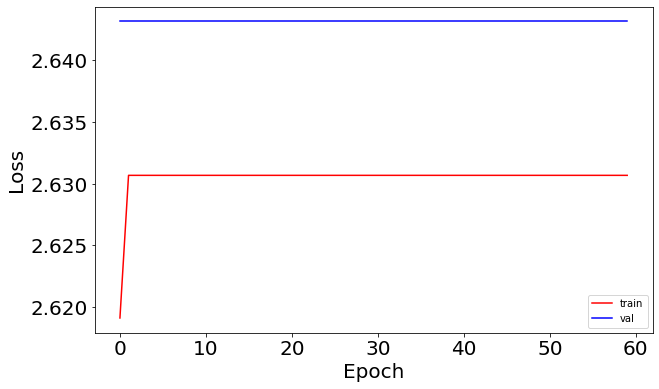

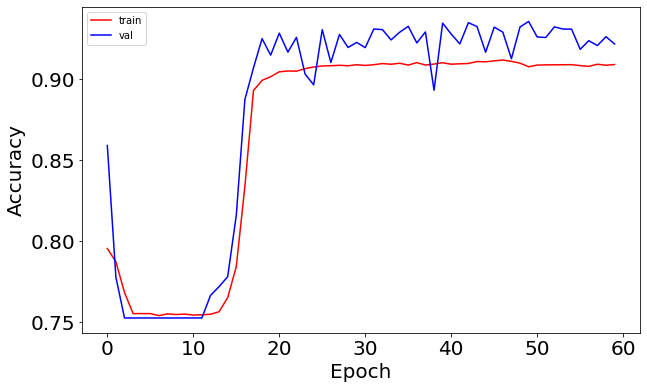

In [83]:
# Model with customized learning rate results
score = exponential_decay_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

loss_fn(exponential_decay_model_history)
acc_plot(exponential_decay_model_history)

In [0]:
# 3. Using RMS Optimizer
# Building the model
input_dim = X.shape[1]

model = Sequential()
model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim)) # fully-connected layer with 64 hidden units
model.add(Dropout(0.1))
model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))


Train on 116568 samples, validate on 49959 samples
Epoch 1/60
116568/116568 [==============================] - 2s 16us/step - loss: 0.2574 - acc: 0.9013 - val_loss: 0.2026 - val_acc: 0.9229
Epoch 2/60
116568/116568 [==============================] - 2s 14us/step - loss: 0.1876 - acc: 0.9325 - val_loss: 0.1668 - val_acc: 0.9394
Epoch 3/60
116568/116568 [==============================] - 2s 13us/step - loss: 0.1687 - acc: 0.9399 - val_loss: 0.1437 - val_acc: 0.9457
Epoch 4/60
116568/116568 [==============================] - 2s 14us/step - loss: 0.1564 - acc: 0.9445 - val_loss: 0.1230 - val_acc: 0.9561
Epoch 5/60
116568/116568 [==============================] - 2s 14us/step - loss: 0.1477 - acc: 0.9478 - val_loss: 0.1766 - val_acc: 0.9365
Epoch 6/60
116568/116568 [==============================] - 2s 13us/step - loss: 0.1384 - acc: 0.9511 - val_loss: 0.1111 - val_acc: 0.9587
Epoch 7/60
116568/116568 [==============================] - 2s 14us/step - loss: 0.1316 - acc: 0.9537 - val_loss: 0

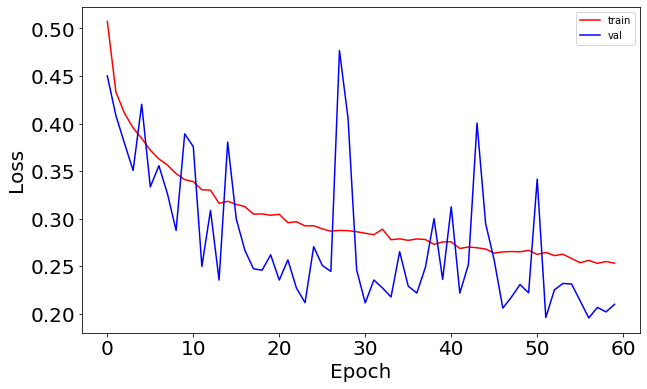

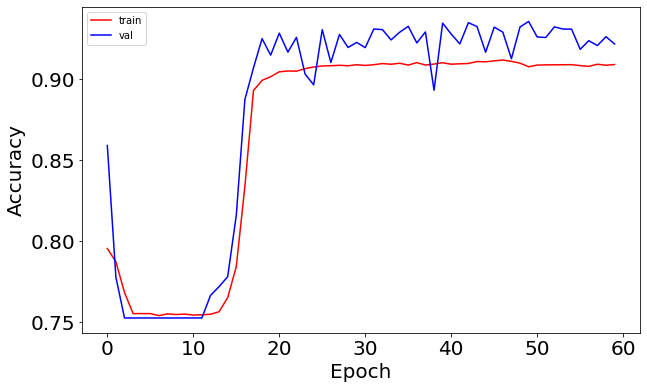

In [85]:
# defining the parameters for RMSprop (I used the keras defaults here)
rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy',optimizer=rms,metrics=['acc'])
batch_size = 200
epochs = 60
model_history = model.fit(X, y,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

loss_fn(model_history)
acc_plot(model_history)

In [0]:
# 4. Hyper parameter tuning for ANN

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# let's create a function that creates the model (required for KerasClassifier) 
# while accepting the hyperparameters we want to tune 
# we also pass some default values such as optimizer='rmsprop'
def create_model(init_mode='uniform'):
    # define model
    model = Sequential()
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=X.shape[1])) 
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu))
    model.add(Dense(2, kernel_initializer=init_mode, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
    return model

In [87]:
# Hyper-parameter tuned : bacth size
model_init_batch_epoch_CV = KerasClassifier(build_fn=create_model, verbose=1)
batches = [200, 300,400]
epochs = 20
param_grid = dict( batch_size=batches)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, param_grid=param_grid,cv=3)
grid_result = grid.fit(X, y,validation_data=(X_test, y_test))
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Train on 77712 samples, validate on 49959 samples
Epoch 1/1
38856/38856 [==============================] - 0s 4us/step
Train on 77712 samples, validate on 49959 samples
Epoch 1/1
38856/38856 [==============================] - 0s 5us/step
Train on 77712 samples, validate on 49959 samples
Epoch 1/1
38856/38856 [==============================] - 0s 4us/step
Train on 77712 samples, validate on 49959 samples
Epoch 1/1
38856/38856 [==============================] - 0s 4us/step
Train on 77712 samples, validate on 49959 samples
Epoch 1/1
38856/38856 [==============================] - 0s 4us/step
Train on 77712 samples, validate on 49959 samples
Epoch 1/1
38856/38856 [==============================] - 0s 3us/step
Train on 77712 samples, validate on 49959 samples
Epoch 1/1
38856/38856 [==============================] - 0s 3us/step
Train on 77712 samples, validate on 49959 samples
Epoch 1/1
38856/38856 [==============================] - 0s 3us/step
Train on 77712 samples, validate on 49959 sample

In [88]:
# Hyper-parameter tuned : epochs
epochs = [10,20,30,40]
param_grid = dict( epochs=epochs)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, 
                    param_grid=param_grid,
                    cv=3)
grid_result = grid.fit(X, y,validation_data=(X_test, y_test))
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')


Train on 77712 samples, validate on 49959 samples
Epoch 1/10
77712/77712 [==============================] - 6s 83us/step - loss: 0.2271 - acc: 0.9174 - val_loss: 0.2089 - val_acc: 0.9433
Epoch 2/10
77712/77712 [==============================] - 6s 72us/step - loss: 0.1747 - acc: 0.9390 - val_loss: 0.1867 - val_acc: 0.9434
Epoch 3/10
77712/77712 [==============================] - 6s 72us/step - loss: 0.1514 - acc: 0.9481 - val_loss: 0.1284 - val_acc: 0.9607
Epoch 4/10
77712/77712 [==============================] - 6s 72us/step - loss: 0.1357 - acc: 0.9527 - val_loss: 0.1089 - val_acc: 0.9669
Epoch 5/10
77712/77712 [==============================] - 6s 72us/step - loss: 0.1255 - acc: 0.9583 - val_loss: 0.1640 - val_acc: 0.9426
Epoch 6/10
77712/77712 [==============================] - 6s 71us/step - loss: 0.1176 - acc: 0.9613 - val_loss: 0.1129 - val_acc: 0.9650
Epoch 7/10
77712/77712 [==============================] - 6s 72us/step - loss: 0.1099 - acc: 0.9643 - val_loss: 0.0811 - val_acc

In [89]:
# Hyper-parameter tuned : initialisation mode
seed = 7
batch_size = 400
epochs = 10
model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)

print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/10
116568/116568 [==============================] - 3s 25us/step - loss: 0.8909 - acc: 0.8257
Epoch 2/10
116568/116568 [==============================] - 1s 9us/step - loss: 0.4224 - acc: 0.8711
Epoch 3/10
116568/116568 [==============================] - 1s 9us/step - loss: 0.3365 - acc: 0.8918
Epoch 4/10
116568/116568 [==============================] - 1s 9us/step - loss: 0.2832 - acc: 0.9057
Epoch 5/10
116568/116568 [==============================] - 1s 9us/step - loss: 0.2489 - acc: 0.9154
Epoch 6/10
116568/116568 [==============================] - 1s 9us/step - loss: 0.2160 - acc: 0.9269
Epoch 7/10
116568/116568 [==============================] - 1s 9us/step - loss: 0.2014 - acc: 0.9321
Epoch 8/10
116568/116568 [==============================] - 1s 9us/step - loss: 0.1842 - acc: 0.9375
Epoch 9/10
116568/116568 [==============================] - 1s 9us/step - loss: 0.1746 - acc: 0.9412
Epoch 10/10
116568/116568 [==============================] - 1s 9us/step - loss: 0.1632 - 

In [0]:
# # Hyper-parameter tuning using grid search

def create_model_2(optimizer='rmsprop', init='glorot_uniform'):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, kernel_initializer=init, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init, activation=tf.nn.relu))
    model.add(Dense(num_classes, kernel_initializer=init, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Creating the sklearn model for the network
model_init_batch_epoch_CV = KerasClassifier(build_fn=create_model_2, verbose=1)


In [0]:
# Using the best results that came at the top in the previous cross-validation!!
init_mode = ['glorot_uniform', 'uniform'] 
batches = [300, 400]
epochs = [10, 20]

In [92]:
# grid search for initializer, batch size and number of epochs
param_grid = dict(epochs=epochs, batch_size=batches, init=init_mode)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, param_grid=param_grid,cv=3)
grid_result = grid.fit(X, y)

print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')


Epoch 1/10
77712/77712 [==============================] - 2s 32us/step - loss: 0.6947 - acc: 0.8291
Epoch 2/10
77712/77712 [==============================] - 1s 10us/step - loss: 0.3838 - acc: 0.8737
Epoch 3/10
77712/77712 [==============================] - 1s 10us/step - loss: 0.3095 - acc: 0.8912
Epoch 4/10
77712/77712 [==============================] - 1s 10us/step - loss: 0.2604 - acc: 0.9064
Epoch 5/10
77712/77712 [==============================] - 1s 10us/step - loss: 0.2327 - acc: 0.9175
Epoch 6/10
77712/77712 [==============================] - 1s 10us/step - loss: 0.2111 - acc: 0.9258
Epoch 7/10
77712/77712 [==============================] - 1s 10us/step - loss: 0.1940 - acc: 0.9326
Epoch 8/10
77712/77712 [==============================] - 1s 10us/step - loss: 0.1789 - acc: 0.9385
Epoch 9/10
77712/77712 [==============================] - 1s 10us/step - loss: 0.1682 - acc: 0.9424
Epoch 10/10
38856/38856 [==============================] - 1s 22us/step
Epoch 1/10
77712/77712 [====

In [102]:
# Checking this ANN best model performance on test data
dnn_best = KerasClassifier(build_fn=create_model_2, epochs=20, batch_size=400, verbose=1) #which uses init = 'glorot_uniform'
dnn_best_result = dnn_best.fit(X,y)
y_pred = dnn_best.predict(X_test)

Epoch 1/20
116568/116568 [==============================] - 4s 38us/step - loss: 0.6376 - acc: 0.8420
Epoch 2/20
116568/116568 [==============================] - 1s 10us/step - loss: 0.3227 - acc: 0.8854
Epoch 3/20
116568/116568 [==============================] - 1s 9us/step - loss: 0.2625 - acc: 0.9048
Epoch 4/20
116568/116568 [==============================] - 1s 10us/step - loss: 0.2250 - acc: 0.9202
Epoch 5/20
116568/116568 [==============================] - 1s 10us/step - loss: 0.2002 - acc: 0.9294
Epoch 6/20
116568/116568 [==============================] - 1s 10us/step - loss: 0.1794 - acc: 0.9369
Epoch 7/20
116568/116568 [==============================] - 1s 10us/step - loss: 0.1664 - acc: 0.9424
Epoch 8/20
116568/116568 [==============================] - 1s 10us/step - loss: 0.1564 - acc: 0.9454
Epoch 9/20
116568/116568 [==============================] - 1s 10us/step - loss: 0.1472 - acc: 0.9494
Epoch 10/20
116568/116568 [==============================] - 1s 10us/step - loss: 0

In [110]:
# Accuracy of best DNN Model
accuracy = np.sum(y_test[:,1]==y_pred)
actual = y_test.shape[0]
print('Accuracy: %.2f' % (accuracy/actual*100))

Accuracy: 96.11
